#   IAU Zadanie - Aktivita na cviceni

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

#### Import vsetkych potrebnych kniznic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Pre prácu s obrazkami
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/faces-age-detection-dataset/versions/2


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 14 17:27:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 4.1.A

### EDA

#### Základne informácie o datasete

In [4]:
# Locate the train.csv file
csv_path = os.path.join(path, "faces/train.csv")
images_path = os.path.join(path, "faces/Train")

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Display dataset information
print("Dataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None

First 5 rows:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


#### Analýza distribúcie tried


Class distribution:
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


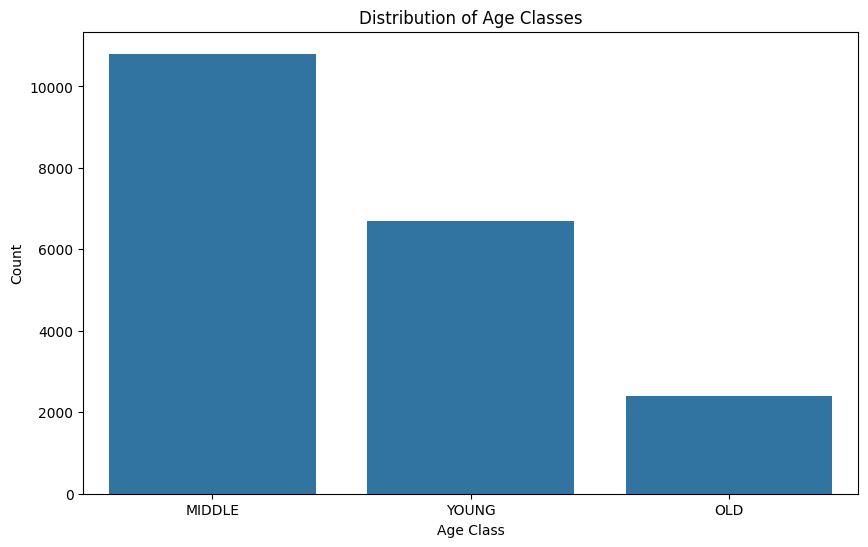

In [5]:
class_distribution = df['Class'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Vizualizácia distribúcie
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Age Classes')
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.show()

Vzhľadom na to, že máme nepomer tried, tak nastavíme pri trénovaní rozdielne váhy pre triedy aby sme optimalizovali učenie modelov.

#### Analýza obrazkov

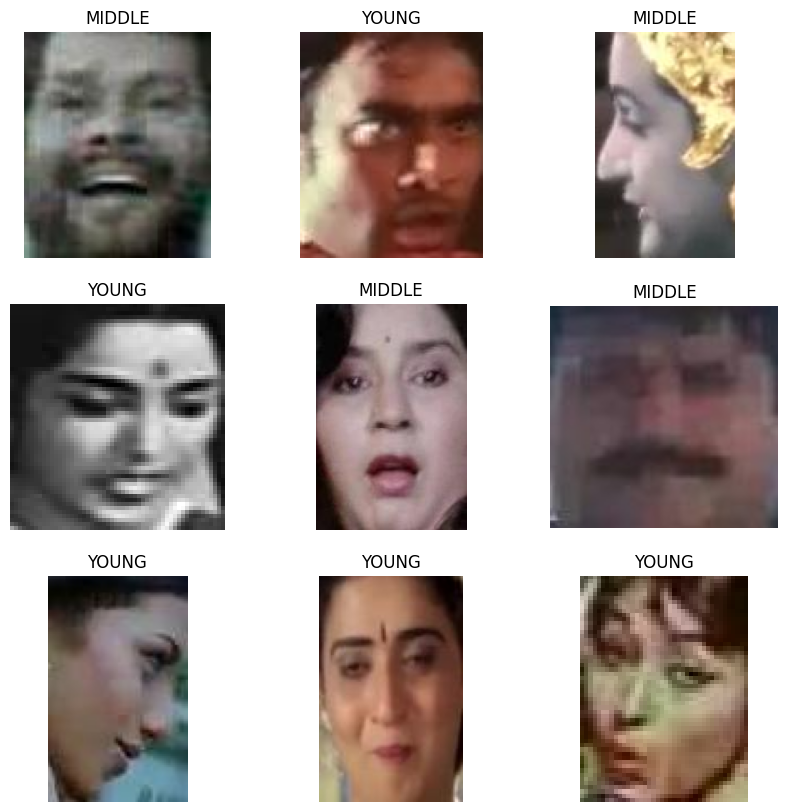

In [6]:
# Zobrazenie niekoľkých obrázkov
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(images_path, df['ID'][i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
    plt.title(df['Class'][i])
    plt.axis('off')
plt.show()

#### Ako mozme vidiet, obrazky nie su rovnakej velkosti a nemaju rovnaku kvalitu, tak musime spravit nejaky preproccesing

### Preprocessing

#### V tomto kode
- Štandardizujeme veľkosť všetkých obrázkov
- Normalizujeme hodnoty pixelov do rozsahu 0-1
- Rozdelíme dataset na trénovaciu a validačnú časť
- Vytvoríme efektívny generátor dát pre trénovanie

In [7]:
# Definujeme konštanty pre preprocessing
TARGET_SIZE = (224, 224)  # štandardná veľkosť pre mnohé CNN architektúry
BATCH_SIZE = 128  # veľkosť dávok pre tréning

# Enkódovanie labelov
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])

df.head(10)

,ID,Class,Class_encoded
0,377.jpg,MIDDLE,0
1,17814.jpg,YOUNG,2
2,21283.jpg,MIDDLE,0
3,16496.jpg,YOUNG,2
4,4487.jpg,MIDDLE,0
5,6283.jpg,MIDDLE,0
6,23495.jpg,YOUNG,2
7,7100.jpg,YOUNG,2
8,6028.jpg,YOUNG,2
9,22617.jpg,OLD,1


In [8]:
# Rozdelenie na tréning, validačnú a testovaciu množinu
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Training set size: 13934
Validation set size: 2986
Test set size: 2986


Found 13934 validated image filenames belonging to 3 classes.
Found 2986 validated image filenames belonging to 3 classes.
Found 2986 validated image filenames belonging to 3 classes.


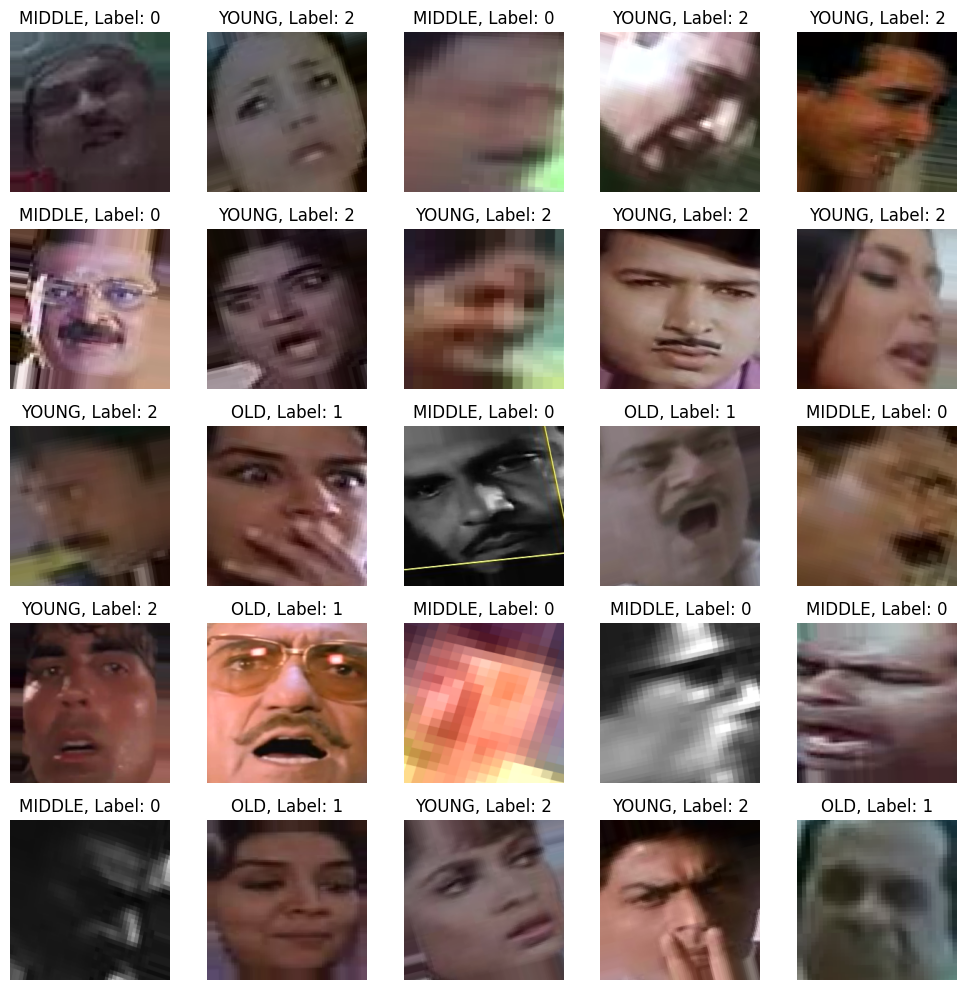

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definícia augmentačného generátora pre tréning
train_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalizácia pixelov na rozsah 0-1
    horizontal_flip=True,  # Horizontálne zrkadlenie s pravdepodobnosťou 50%
    rotation_range=15,  # Rotácia do ±15 stupňov
    brightness_range=(0.8, 1.2),  # Jemná úprava jasu
    zoom_range=0.2,  # Náhodné priblíženie/oddialenie
    shear_range=0.2,  # Náklon obrázkov
    fill_mode="nearest"  # Vyplnenie okrajov pri transformáciách
)

# Generátor len pre normalizáciu na validačné a testovacie dáta
val_test_normalization = ImageDataGenerator(rescale=1.0 / 255)

# Tréningový generátor
train_gen = train_augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,  # Rozmery obrázkov
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Kategórie (jedno-hot encoding)
    shuffle=True  # Náhodné miešanie dávok
)

# Validačný generátor (len normalizácia)
val_gen = val_test_normalization.flow_from_dataframe(
    dataframe=val_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Testovací generátor (len normalizácia, nemieša poradie)
test_gen = val_test_normalization.flow_from_dataframe(
    dataframe=test_df,
    directory=images_path,
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Zachovanie poradia pre presné vyhodnotenie
)

augmented_images, labels = next(train_gen)  # Získa jednu dávku obrázkov z generátora

# Zobrazenie 5x5 => 25 augmentovaných obrázkov
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(label_encoder.inverse_transform([np.argmax(labels[i])])[0] + ", Label: " + str(np.argmax(labels[i])))
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4.1.B

### Pre Age Detection dataset navrhujeme použiť Konvolučnú neurónovú sieť (CNN), konkrétne architektúru založenú na ResNet50. Zdôvodnenie výberu:

#### Charakter dát:

- Pracujeme s obrázkami tvárí
- Máme 3 triedy (YOUNG, MIDDLE, OLD)
- Dataset obsahuje veľké množstvo vzoriek (19906 obrázkov)
- Obrázky majú rôznu kvalitu a veľkosť


#### Prečo CNN?

- CNN sú špecializované na spracovanie obrazových dát
- Automaticky sa učia hierarchiu príznakov - od jednoduchých hrán až po komplexné vzory
- Dokážu si poradiť s variabilitou v pozícii a veľkosti príznakov
- Sú robustné voči menším zmenám v obrázkoch


#### Prečo konkrétne ResNet50:

- Hlboká architektúra umožňuje zachytiť komplexné vzory starnutia
- Residuálne spojenia pomáhajú s problémom miznúceho gradientu
- Je predtrénovaná na ImageNet, čo umožňuje transfer learning
- Dokázala svoju efektivitu v podobných úlohách klasifikácie tvárí


#### Alternatívy, ktoré boli zvážené:

- VGG16/19: Jednoduchšia architektúra, ale náchylnejšia na preučenie
- MobileNet: Ľahšia architektúra, ale môže byť nedostatočne komplexná
- Custom CNN: Potrebovala by dlhší čas na tréning a ladenie

## 4.2.A

### Vytvorenie modelu Xception

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xduvac (xduvac-fiit-stu). Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.4689 - loss: 1.0131 - val_accuracy: 0.5630 - val_loss: 0.8950
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.5496 - loss: 0.9035 - val_accuracy: 0.6149 - val_loss: 0.8370
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5762 - loss: 0.8620 - val_accuracy: 0.5144 - val_loss: 0.9431
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5718 - loss: 0.8500 - val_accuracy: 0.6082 - val_loss: 0.8427
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5827 - loss: 0.8328 - val_accuracy: 0.5854 - val_loss: 0.8636
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.5834 - loss: 0.8379 - val_accuracy: 0.5747 - val_loss: 0.8783
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5939 - loss: 0.8254 - val_accuracy: 0.6025 - val_loss: 0.8375
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6257 - loss: 0.8297

Validation Loss: 0.8370, Validat

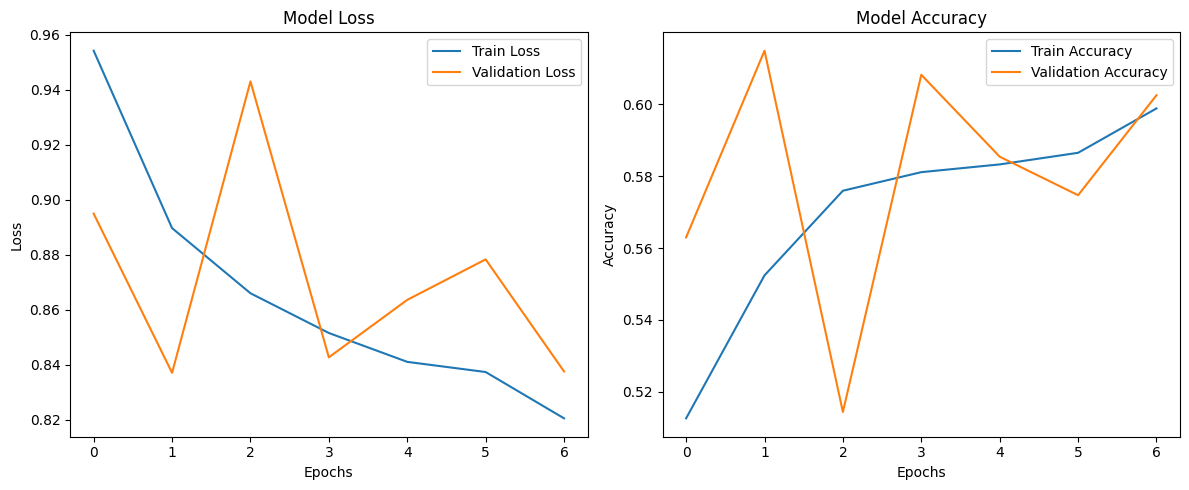

epoch/accuracy,▁▄▆▇▇▇█
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▁
epoch/val_accuracy,▄█▁█▆▅▇
epoch/val_loss,▅▁█▁▃▄▁
epoch/accuracy,0.59882
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.82046
epoch/val_accuracy,0.60248


In [10]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger
from sklearn.utils.class_weight import compute_class_weight

# Initialize W&B
wandb.init(
    project="age-detection",
    config={
        "model_name": "Xception",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "dropout_rate": 0.3,
        "dense_units": 256,
        "learning_rate": 1e-3,
        "batch_size": BATCH_SIZE,
        "epochs": 20,
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

# Define Xception Model
def create_xception(input_shape, num_classes, dropout_rate, dense_units):
    # Load Xception as base model
    base_model = Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),                       # Pooling layer
        Dropout(dropout_rate),                          # Dropout for regularization
        Dense(dense_units, activation="relu"),          # Fully connected layer
        Dropout(dropout_rate),                          # Additional dropout
        Dense(num_classes, activation="softmax")        # Output layer for classification
    ])
    return model

# Create the model
model = create_xception(
    input_shape=config.input_shape,
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate,
    dense_units=config.dense_units
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=config.metrics
)

# Callbacks
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(filepath=".keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["Class_encoded"]),
    y=train_df["Class_encoded"]
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

print('\n')
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot training and validation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

### Predikcia modelu Xception

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


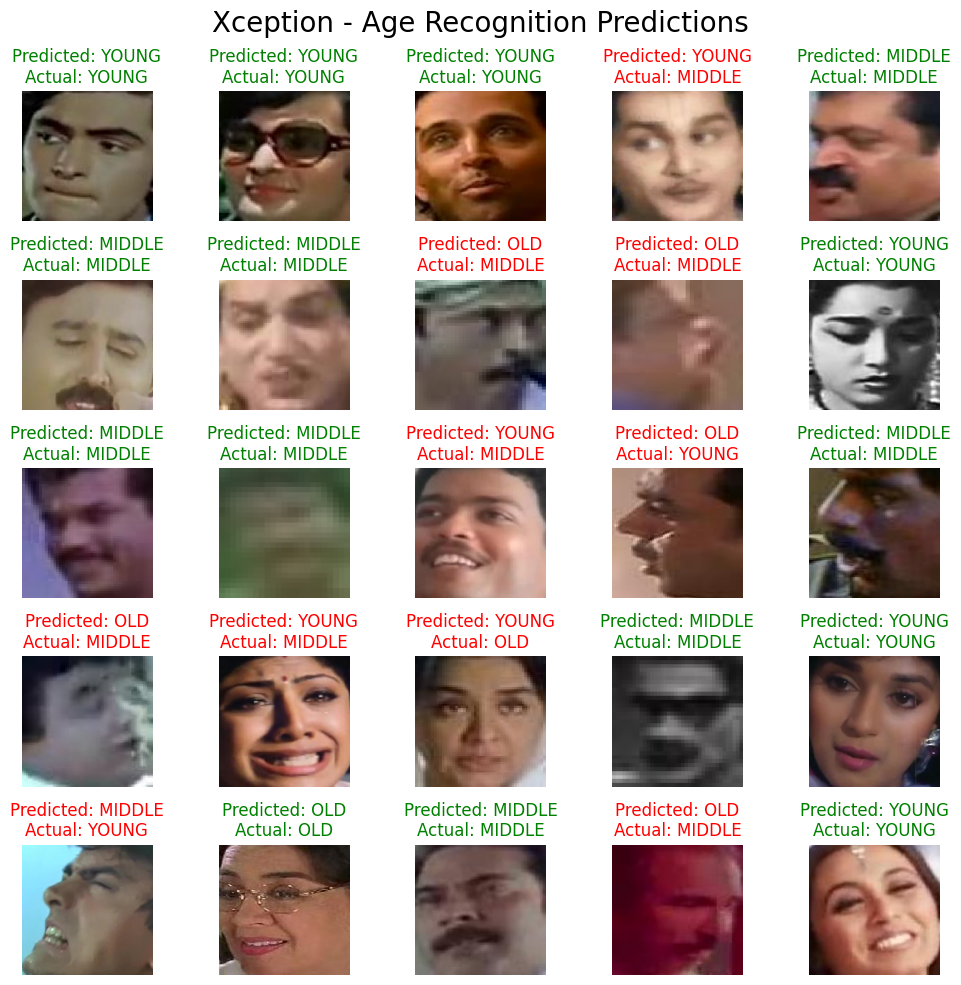

In [12]:
test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("Xception - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()